# CSCI-UA 0473 - Introduction to Machine Learning
## Wednesday, April 11, 2018

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.sparse import diags
%matplotlib inline

from sklearn import datasets
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import autograd
import autograd.numpy as numpy
import autograd.numpy.random as npr

from autograd import grad

import scipy.optimize

## 1. Data

In [2]:
newsgroups_train = datasets.fetch_20newsgroups(subset='train', 
                                               categories=['comp.sys.mac.hardware', 'rec.motorcycles', 'sci.med', 'soc.religion.christian'])

In [3]:
tfidf_vectorizer = TfidfVectorizer(min_df=30, stop_words='english')
X = tfidf_vectorizer.fit_transform(newsgroups_train.data).toarray()
y = newsgroups_train.target
print (X.shape)

(2369, 1529)


In [4]:
X = np.transpose(X)

def normalize(data):
    mean = np.mean(data, axis=1)[:,None]
    return data - mean

(d, N) = X.shape
q = 10

print ("d",  d)
print ("N", N)
print ("q", q)

print ("X", (d, N))
print ("W", (d, q))
print ("Z", (q, N))
# X : (d, N)
# W : (d, q)
# Z : (q, N)

d 1529
N 2369
q 10
X (1529, 2369)
W (1529, 10)
Z (10, 2369)


In [5]:
choose_which = "nmf"
# "compute_c", "svd", "sgd", "nmf"

In [6]:
if choose_which == "nmf":
    X = X - np.min(X)
else:
    X = normalize(X)

In [7]:
if choose_which == "svd":
    W, S, V = linalg.svd(X)
    print ("X", X.shape)
    print ("W", W.shape)
    print ("S", S.shape) 
    print ("V", V.shape)
    
    #Sig = np.diag(S * S)
    #print (Sig.shape)
    #C = W * Sig * np.transpose(W)
    
elif choose_which == "compute_c":    
    C = X @ np.transpose(X)
    e_val, W = np.linalg.eig(C)
    W = autograd.numpy.real( W )
    
    print ("C", C.shape)
    print ("e_val", e_val.shape)
    print ("W", W.shape)
    
elif choose_which == "sgd":
    def print_diff(W):
        W2 = W @ np.transpose(W)
        dd = np.mean(np.identity(d) - W2)
        norm = np.mean(W2)
        print ("W     (Norm | Max | Min) : ({:.8f} | {:.8f} | {:.8f})".format(np.linalg.norm(W), np.max(W), np.min(W)))
        print ("WW^T (Diff | Norm) : ({:.8f}, {:.8f})".format(dd, norm) )
    
    def dist(W, X, d, q):
        W = W.reshape(d, q)
        dd = X - W @ autograd.numpy.transpose(W) @ X
        norm = autograd.numpy.linalg.norm( dd )
        return norm * norm
    
    #maxiter = 100
    W = autograd.numpy.real( autograd.numpy.random.rand(d,q) )
    print ('start optimising...')
    print_diff(W)
    trained_model = scipy.optimize.minimize(dist, W, (X, d, q), method='CG', jac=grad(dist))
    #trained_model = scipy.optimize.minimize(dist, W, (X, d, q), method='CG', jac=grad(dist), options={'maxiter':maxiter})
    print ('optimisation finished')
    W = trained_model.x.reshape(d,q)
    print_diff(W)
    
elif choose_which == "nmf":    
    multiplicative = True
    maxiter = 1000
    W = np.real( (np.random.rand(d,q))*0.5 )
    Z = np.real( (np.random.rand(q,N))*0.5 )
    print ('start optimising...')
    # X : (d, N)
    # W : (d, q)
    # Z : (q, N)        
    for u_iter in range(maxiter):
        if multiplicative:
            diff = X - W @ Z
            Z = Z * (np.transpose(W) @ X) / (np.transpose(W) @ W @ Z)
            W = W * (X @ np.transpose(Z)) / (W @ Z @ np.transpose(Z))

        else:
            lr = 0.0001
            W_ = W + lr * (diff) @ np.transpose(Z)
            Z_ = Z + lr * np.transpose(W) @ (diff)       

            W, Z = np.maximum(W_, 0, W_), np.maximum(Z_, 0, Z_)

        if u_iter % 50 == 0:
            print (autograd.numpy.linalg.norm(diff))
        
    print ('optimisation finished')


start optimising...
1223.9787903452484
45.538633308831386
45.52380319322538
45.5212356607746
45.52056434407838
45.52017594628473
45.5200018614657
45.519939379213945
45.519910037161814
45.51988334186786
45.51986330321748
45.51984376557059
45.51981781545874
45.51976578333468
45.519464992568835
45.511382883004664
45.50856012227915
45.507026154399114
45.505961820190365
45.50529842299815
optimisation finished


In [8]:
# X : (d, N)
# W : (d, q)
# Z : (q, N)

W_q = np.transpose(W[:,:q])
# (q, d)

if choose_which == "nmf":
    Z = np.transpose(Z)
    #Z = np.transpose(np.matmul(W_q, X))
else:
    Z = np.transpose(np.matmul(W_q, X))

## 2. PCA - Principal Components Analysis

In [9]:
print ('Original Shape: ', X.shape)
print ('Reduced Shape: ', Z.shape)

Original Shape:  (1529, 2369)
Reduced Shape:  (2369, 10)


## 3. Visualizing the reduced data points

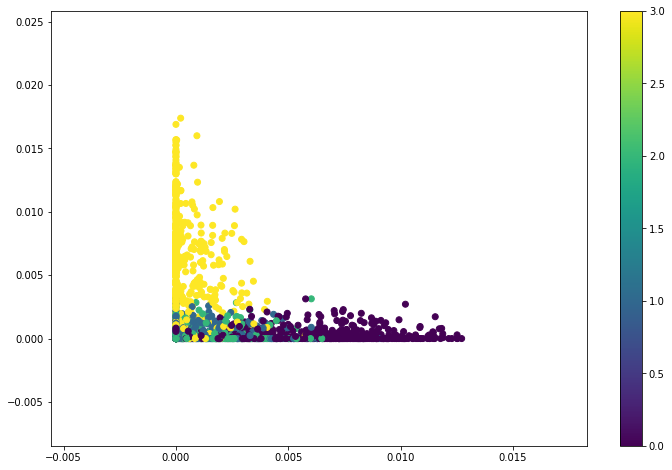

In [55]:
plt.figure(figsize=(12, 8))
plt.scatter(Z[:, 0], Z[:, 8], c = y)
plt.colorbar()

## 4. Analysis

In [17]:
invocab = dict([(vv,kk) for kk, vv in tfidf_vectorizer.vocabulary_.items()])

for i in range(q):
    insens_idx = np.argsort(W_q[i])

    print ('TOPIC ' + str(i))
    print (' '.join([invocab[w_ix] for w_ix in insens_idx[-10:]]) + '\n')

TOPIC 0
simms university monitor host nntp posting se mac apple edu

TOPIC 1
cd quadra internal hard apple disk drives mac scsi drive

TOPIC 2
aisun3 programs edu athens mcovingt covington michael uga georgia ai

TOPIC 3
posting hp ed nec behanna east writes article sun com

TOPIC 4
chastity shameful dsl cadre edu cs gordon banks geb pitt

TOPIC 5
reaction foods steve berkeley dyer superstition chinese sensitivity food msg

TOPIC 6
dog riding bmw edu ride uk dod bnr ca bike

TOPIC 7
people don know patients time medical science doctor disease edu

TOPIC 8
believe edu people christianity bible truth jesus christian christians church

TOPIC 9
faith believe life lord christ heaven sin jesus hell god



In [45]:
# Z : (N, q)
# y : N
res = [[], [], [], []]
for idx in range(N):
    yy = y[idx]
    res[yy].append( Z[idx] )
    
cats = ['comp.sys.mac.hardware', 'rec.motorcycles', 'sci.med', 'soc.religion.christian']
qq = np.array(range(q))
    
res = np.array([np.mean(np.array(x), axis=0) for x in res])
res = [x/np.sum(x)*100 for x in res]
res = [qq[x > 25] for x in res]

for idx in range(4):
    print ("Category {} | Topics {}".format(cats[idx], ", ".join([str(x) for x in res[idx]])))

Category comp.sys.mac.hardware | Topics 0, 1
Category rec.motorcycles | Topics 3, 6
Category sci.med | Topics 7
Category soc.religion.christian | Topics 8, 9
